In [1]:
import numpy as np
import matplotlib.pyplot as plt

from model import (
    SpotBiLSTM,
    train_model,
    find_lr,
    model_forecast,
)
from load_spot_dataset import LoadSpotDataset
from spot_dataset import SpotPriceDataset
from utils import plot_series, get_device

## Load variables from config file

## Load data

In [2]:
lsd = LoadSpotDataset("config.yaml", "data")

prices_df, instance_info_df = lsd.load_data()

In [3]:
prices_df.head()

,price_timestamp,id_instance,spot_price
0,2024-04-01 00:00:00+00:00,8364,0.0438
1,2024-04-01 00:00:00+00:00,44263,2.2684
2,2024-04-01 00:00:00+00:00,39658,1.0328
3,2024-04-01 00:00:00+00:00,19681,12.5172
4,2024-04-01 00:00:00+00:00,39617,7.8889


In [4]:
instance_info_df.head()

,region,av_zone,instance_type,instance_family,generation,modifiers,size,vcpu,memory,architectures,product_description,on_demand_price
id_instance,,,,,,,,,,,,
48207,us-east-1,b,c6a.8xlarge,c,6,[a],8xlarge,32,65536,[x86_64],Linux/UNIX,1.224
6910,us-east-1,c,c6a.8xlarge,c,6,[a],8xlarge,32,65536,[x86_64],Linux/UNIX,1.224
32082,us-east-1,f,c6a.8xlarge,c,6,[a],8xlarge,32,65536,[x86_64],Linux/UNIX,1.224
39235,us-east-1,a,c6a.8xlarge,c,6,[a],8xlarge,32,65536,[x86_64],Linux/UNIX,1.224
17992,us-east-1,d,c6a.8xlarge,c,6,[a],8xlarge,32,65536,[x86_64],Linux/UNIX,1.224


# Feature engineering and sequencing

## Feature engineering

| **Column**                | **Encoding**              | **Notes**                                                                 |
|---------------------------|---------------------------|---------------------------------------------------------------------------|
| `region_avzone`           | Embedding                 | Combine region and av_zone for better contextual encoding.                |
| `product_description`     | One-hot                   | Two values; one-hot is simpler and explicit.                              |
| `instance_family`         | Embedding                 | Embed if there are many unique families (x > 10).                         |
| `generation`              | Numerical                 | Direct mapping as ordinal (e.g., 6).                                      |
| `modifiers`                | Multi-hot encoding        | Each letter represents an independent property.                           |
| `size`                    | Numerical                 | Map sizes to integers (e.g., xlarge=1, 2xlarge=2, etc.).                  |
| `vcpu`                    | Numerical                 | Include as-is, correlated with performance.                               |
| `memory`                  | Numerical                 | Include as-is, correlated with performance.                               |
| `architectures`           | One-hot                   | Only two values; one-hot preferred for clarity.                           |


## Hyperparameter Tuning

In [5]:
device = get_device()

dataset_config = {
    "sequence_length": 28,
    "window_step": 4,
    "batch_size": 32
}
train_df, val_df, test_df = lsd.get_training_validation_test_split(prices_df)

train_dataset = SpotPriceDataset(train_df, dataset_config, device)
train_loader = train_dataset.get_data_loader()

val_dataset = SpotPriceDataset(val_df, dataset_config, device)
val_loader = val_dataset.get_data_loader()

### Learning Rate Range Test


Loss exploding, stopping early...

Optimal learning rate: 6.00e-07


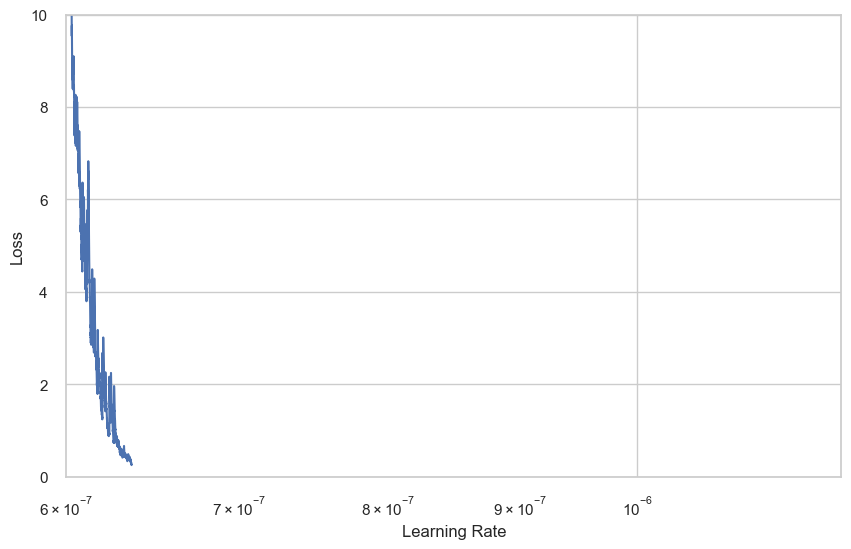

In [ ]:
def lr():
    # Model configuration
    model_config = {
        "hidden_size": 64,        # Increased capacity
        "output_scale": 100.0,
        "window_size": 20,
        "batch_size": 128,        # Smaller for better generalization
        "shuffle_buffer": 1000,
        "epochs": 150,           # More training time
        "steps_per_epoch": len(train_dataset),
        "init_learning_rate": 6e-7,
        "final_learning_rate": 1.2e-6,
        "weight_decay": 1.5e-5,
        "mse_weight": 0.8
    }
    model = SpotBiLSTM(model_config, device)

    log_lrs, losses = find_lr(model, train_loader, model_config, device)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.grid(True)
    plt.semilogx(10**np.array(log_lrs), losses)
    plt.tick_params('both', length=10, width=1, which='both')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.axis([model_config["init_learning_rate"], model_config["final_learning_rate"], 0, 10])
    plt.show()
    
lr()


Loss exploding, stopping early...

Optimal learning rate: 6.02e-07


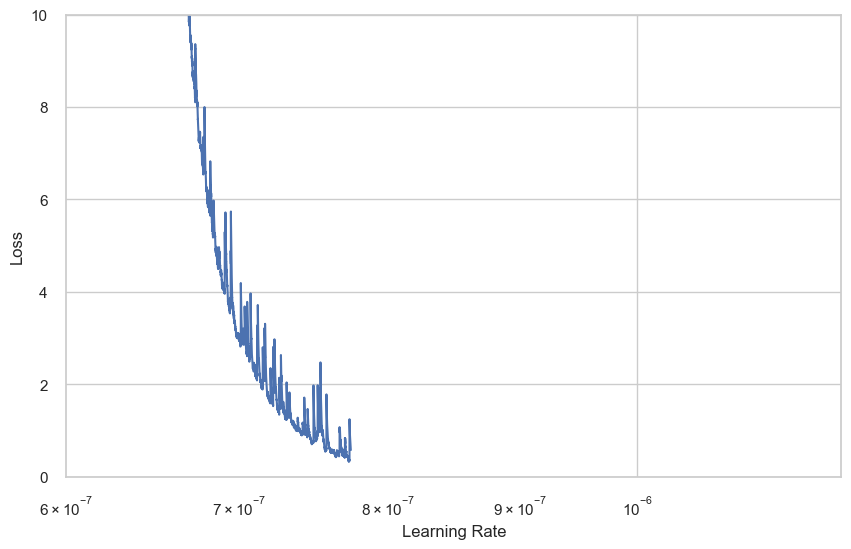

In [7]:
def lr():
    # Model configuration
    model_config = {
        "hidden_size": 32,        # Increased capacity
        "output_scale": 100.0,
        "window_size": 20,
        "batch_size": 128,        # Smaller for better generalization
        "shuffle_buffer": 1000,
        "epochs": 150,           # More training time
        "steps_per_epoch": len(train_dataset),
        "init_learning_rate": 6e-7,
        "final_learning_rate": 1.2e-6,
        "weight_decay": 1.5e-5,
        "mse_weight": 0.8
    }
    model = SpotBiLSTM(model_config, device)

    log_lrs, losses = find_lr(model, train_loader, model_config, device)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.grid(True)
    plt.semilogx(10**np.array(log_lrs), losses)
    plt.tick_params('both', length=10, width=1, which='both')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.axis([model_config["init_learning_rate"], model_config["final_learning_rate"], 0, 10])
    plt.show()
    
lr()

### Model Training with Selected Learning Rate

In [ ]:
model_config = {
    "hidden_size": 64,
    "n_layers": 2,
    "output_scale": 100.0,
    "window_size": 20,
    "batch_size": 128,
    "shuffle_buffer": 1000,
    "epochs": 100,
    "learning_rate": 6.00e-07,
    "steps_per_epoch": len(train_loader),
    "weight_decay": 1e-5
}
model = SpotBiLSTM(model_config, device)
history = train_model(model, train_loader, model_config, device, val_loader)

/Users/adf/.pyenv/versions/miniforge3-22.9.0-3/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(



Training for 100 epochs



Epoch 1/100
├─ Train Loss: 0.021146
├─ Val Loss: 0.005914
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 33.25



Epoch 2/100
├─ Train Loss: 0.010177
├─ Val Loss: 0.006493
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 5.86



Epoch 3/100
├─ Train Loss: 0.009240
├─ Val Loss: 0.004796
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 14.60



Epoch 4/100
├─ Train Loss: 0.008688
├─ Val Loss: 0.008391
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 38.16



Epoch 5/100
├─ Train Loss: 0.008020
├─ Val Loss: 0.027497
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 39.64



Epoch 6/100
├─ Train Loss: 0.007804
├─ Val Loss: 0.010930
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 8.45



Epoch 7/100
├─ Train Loss: 0.007537
├─ Val Loss: 0.009796
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 30.59



Epoch 8/100
├─ Train Loss: 0.007168
├─ Val Loss: 0.008685
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 33.80



Epoch 9/100
├─ Train Loss: 0.006860
├─ Val Loss: 0.008487
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 34.24



Epoch 10/100
├─ Train Loss: 0.006848
├─ Val Loss: 0.007984
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 22.92



Epoch 11/100
├─ Train Loss: 0.006512
├─ Val Loss: 0.005994
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 32.12



Epoch 12/100
├─ Train Loss: 0.006280
├─ Val Loss: 0.002960
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 31.84



Epoch 13/100
├─ Train Loss: 0.006753
├─ Val Loss: 0.005363
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 32.72



Epoch 14/100
├─ Train Loss: 0.006311
├─ Val Loss: 0.003999
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 32.69



Epoch 15/100
├─ Train Loss: 0.006057
├─ Val Loss: 0.003514
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 31.68



Epoch 16/100
├─ Train Loss: 0.006581
├─ Val Loss: 0.007665
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 11.51



Epoch 17/100
├─ Train Loss: 0.005768
├─ Val Loss: 0.003426
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 10.97



Epoch 18/100
├─ Train Loss: 0.005964
├─ Val Loss: 0.008836
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 32.48



Epoch 19/100
├─ Train Loss: 0.005787
├─ Val Loss: 0.006648
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 32.22



Epoch 20/100
├─ Train Loss: 0.006041
├─ Val Loss: 0.011842
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 32.87



Epoch 21/100
├─ Train Loss: 0.006080
├─ Val Loss: 0.005331
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 26.91



Epoch 22/100
├─ Train Loss: 0.005936
├─ Val Loss: 0.003707
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 31.10



Epoch 23/100
├─ Train Loss: 0.006207
├─ Val Loss: 0.004850
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 14.55



Epoch 24/100
├─ Train Loss: 0.005818
├─ Val Loss: 0.012851
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 35.30



Epoch 25/100
├─ Train Loss: 0.005981
├─ Val Loss: 0.002199
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 30.32



Epoch 26/100
├─ Train Loss: 0.005605
├─ Val Loss: 0.002535
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 10.45



Epoch 27/100
├─ Train Loss: 0.005839
├─ Val Loss: 0.003522
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 34.32



Epoch 28/100
├─ Train Loss: 0.006218
├─ Val Loss: 0.005265
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 27.52



Epoch 29/100
├─ Train Loss: 0.005577
├─ Val Loss: 0.007782
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 32.07



Epoch 30/100
├─ Train Loss: 0.005706
├─ Val Loss: 0.003287
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 24.99



Epoch 31/100
├─ Train Loss: 0.005185
├─ Val Loss: 0.005930
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 21.48



Epoch 32/100
├─ Train Loss: 0.005410
├─ Val Loss: 0.002168
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 23.08



Epoch 33/100
├─ Train Loss: 0.005071
├─ Val Loss: 0.007717
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 33.00



Epoch 34/100
├─ Train Loss: 0.005555
├─ Val Loss: 0.001818
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 31.58



Epoch 35/100
├─ Train Loss: 0.006172
├─ Val Loss: 0.004105
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 10.72



Epoch 36/100
├─ Train Loss: 0.005494
├─ Val Loss: 0.005367
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 32.58



Epoch 37/100
├─ Train Loss: 0.005531
├─ Val Loss: 0.003430
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 27.59



Epoch 38/100
├─ Train Loss: 0.005653
├─ Val Loss: 0.001968
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 32.89



Epoch 39/100
├─ Train Loss: 0.005714
├─ Val Loss: 0.010109
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 30.06



Epoch 40/100
├─ Train Loss: 0.005723
├─ Val Loss: 0.009665
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 15.87



Epoch 41/100
├─ Train Loss: 0.005746
├─ Val Loss: 0.002112
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 27.49



Epoch 42/100
├─ Train Loss: 0.005391
├─ Val Loss: 0.005147
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 31.38



Epoch 43/100
├─ Train Loss: 0.005416
├─ Val Loss: 0.010313
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 35.67



Epoch 44/100
├─ Train Loss: 0.004893
├─ Val Loss: 0.006175
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 34.80



Epoch 45/100
├─ Train Loss: 0.005499
├─ Val Loss: 0.001310
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 30.47



Epoch 46/100
├─ Train Loss: 0.005510
├─ Val Loss: 0.003796
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 32.45



Epoch 47/100
├─ Train Loss: 0.005489
├─ Val Loss: 0.007501
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 35.49



Epoch 48/100
├─ Train Loss: 0.005961
├─ Val Loss: 0.007079
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 29.72



Epoch 49/100
├─ Train Loss: 0.005223
├─ Val Loss: 0.002734
├─ Learning Rate: 1.00e-03
└─ Gradient Norm: 32.83



Epoch 50/100:  76%|███████▌  | 29849/39186 [05:45<02:24, 64.74it/s, loss=0.003738, lr=1.00e-03, grad_norm=31.73]

NameError: name 'history' is not defined

<Figure size 1000x600 with 0 Axes>

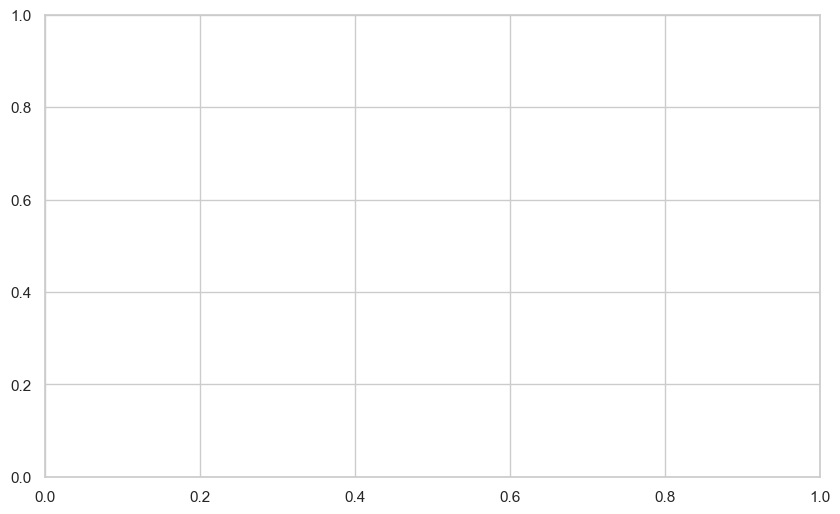

In [3]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

### Model Evaluation

In [2]:
# test_dataset = SpotPriceDataset(test_df, dataset_config, device)

# # Generate predictions
# forecast_series = series[split_time-config["window_size"]:-1]
# forecast = model_forecast(model, forecast_series, config["window_size"], config["batch_size"])

# # Plot results
# plt.figure(figsize=(10, 6))
# plt.plot(time_valid, x_valid, label='Actual')
# plt.plot(time_valid, forecast, label='Forecast')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Calculate metrics
# mse = ((forecast - x_valid) ** 2).mean()
# print(f'MSE: {mse:.6f}')
# print(f'MAE: {mae:.6f}')